# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm  # For progress bar
warnings.filterwarnings('ignore')

# import sys

# sys.path.append('../../') 

# Import custom modules
from libs.data_cleaning import *
from libs.data_extraction import *
from libs.network_analysis import *
from libs.nestedsness_calculator import *
from libs.curveball import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [180]:
country = "us"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 22,527
Investors: 38,843
Investments: 147,832
Funding rounds: 268,283


## VC-Bipartite Network Construction

In [181]:
vc_investments = extract_vc_investments(cleaned_data['investments'])
vc_investments['investor_name'] = vc_investments[['investor_name', 'investment_type']].agg('-'.join, axis=1)

Found 104618 VC investments
Unique companies with VC funding: 16932


In [404]:
min_year = 2004
max_year = 2024
# top_percent = 0.3
lower_percentile=0.005
upper_percentile=0.3
early_stages = set(['angel', 'pre_seed', 'seed', 'series_a'])
late_stages = set(['series_b', 'series_c', 'series_d', 'series_e', 'series_f', 'series_g', 'series_h', 'series_i'])
# early_stages = set(['angel', 'pre_seed', 'seed', 'series_a', 'series_b'])
# late_stages = set(['series_c', 'series_d', 'series_e', 'private_equity'])
# categories = set(['technology', 'software', 'data', 'intelligence', 'health'])
categories = set(['energy'])

category_pattern = '|'.join(categories)
category_mask = vc_investments['category'].str.contains(category_pattern, regex=True, case=False, na=False)

# Count frequency of each investor name
investor_counts = vc_investments['investor_name'].value_counts()
total_investors = len(investor_counts)
sorted_investors = investor_counts.sort_values(ascending=False)

lower_threshold = int(total_investors * lower_percentile)
upper_threshold = int(total_investors * upper_percentile)
mid_range_investors = sorted_investors.iloc[lower_threshold:upper_threshold].index.tolist()

investors_range_mask = vc_investments['investor_name'].isin(mid_range_investors) 

early_stage_mask = vc_investments['investment_type'].isin(early_stages)
late_stage_mask = vc_investments['investment_type'].isin(late_stages)

# Define left and right
vc_right_investments = vc_investments[
  (vc_investments['investor_country'] == 'United States') 
  & (early_stage_mask)
  & (investors_range_mask)
  # & (vc_investments['company_ecosystem'] == 'Silicon Valley')
  # & (~category_mask)
]

vc_left_investments = vc_investments[
  (vc_investments['investor_country'] != 'United States') # vc_investments[vc_investments['investment_type'].isin(late_stages)]
  & (late_stage_mask)
]

# Create pairs
vc_vc_investments_pairs = create_investment_pairs(vc_left_investments, vc_right_investments, 'left_vc', 'right_vc')
vc_vc_investments_pairs['announced_year'] = vc_vc_investments_pairs[['announced_year_left_vc', 'announced_year_right_vc']].max(axis=1)
vc_vc_investments_pairs['year'] = vc_vc_investments_pairs['announced_year']
vc_vc_investments_pairs['total_funding_usd'] = vc_vc_investments_pairs['total_funding_usd_left_vc']
vc_vc_investments_pairs['company_country'] = vc_vc_investments_pairs['company_country_left_vc']
vc_vc_investments_pairs['category'] = vc_vc_investments_pairs['category_left_vc']
# print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'total_funding_usd_left_vc','total_funding_usd_right_vc']].head())

# Display statistics about VC-VC pairs
print(f"Total VC-VC pairs: {len(vc_vc_investments_pairs):,}")
print(f"Total unique companies: {vc_vc_investments_pairs['org_uuid'].nunique():,}")
print(f"Years range: {vc_vc_investments_pairs['year'].min()} to {vc_vc_investments_pairs['year'].max()}")

Created 12356 investment pairs
Covering 1403 unique investors
Total VC-VC pairs: 12,356
Total unique companies: 1,403
Years range: 1999 to 2025


In [405]:
# Calculate and display category distribution
""" print("\nCategory Distribution (Left VCs):")
category_counts = vc_vc_investments_pairs['category'].value_counts()

# Plot the category distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
category_counts.plot(kind='bar', color='skyblue')
plt.title('Left VCs Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Calculate and display investment type distribution
print("\Investment Type Distribution:")
investment_type_left_counts = vc_vc_investments_pairs['investment_type_left_vc'].value_counts()
investment_type_right_counts = vc_vc_investments_pairs['investment_type_right_vc'].value_counts()

# Plot the investment_type_left distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
investment_type_left_counts.plot(kind='bar', color='skyblue')
plt.title('Left VCs Investment Type')
plt.xlabel('Investment Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
investment_type_right_counts.plot(kind='bar', color='skyblue')
plt.title('Right VCs Investment Type')
plt.xlabel('Investment Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Calculate and display investment type distribution
print("\Investor Country Distribution:")
investor_country_left_counts = vc_vc_investments_pairs['investor_country_left_vc'].value_counts()
investor_country_right_counts = vc_vc_investments_pairs['investor_country_right_vc'].value_counts()

# Plot the investor_country_left distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
investor_country_left_counts.plot(kind='bar', color='skyblue')
plt.title('Left VCs Investor Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
investor_country_right_counts.plot(kind='bar', color='skyblue')
plt.title('Right VCs Investor Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show() """

' print("\nCategory Distribution (Left VCs):")\ncategory_counts = vc_vc_investments_pairs[\'category\'].value_counts()\n\n# Plot the category distributions\nplt.figure(figsize=(12, 6))\n\nplt.subplot(1, 2, 1)\ncategory_counts.plot(kind=\'bar\', color=\'skyblue\')\nplt.title(\'Left VCs Categories\')\nplt.xlabel(\'Category\')\nplt.ylabel(\'Count\')\nplt.xticks(rotation=45, ha=\'right\')\n\nplt.tight_layout()\nplt.show()\n\n# Calculate and display investment type distribution\nprint("\\Investment Type Distribution:")\ninvestment_type_left_counts = vc_vc_investments_pairs[\'investment_type_left_vc\'].value_counts()\ninvestment_type_right_counts = vc_vc_investments_pairs[\'investment_type_right_vc\'].value_counts()\n\n# Plot the investment_type_left distributions\nplt.figure(figsize=(12, 6))\n\nplt.subplot(1, 2, 1)\ninvestment_type_left_counts.plot(kind=\'bar\', color=\'skyblue\')\nplt.title(\'Left VCs Investment Type\')\nplt.xlabel(\'Investment Type\')\nplt.ylabel(\'Count\')\nplt.xticks(ro

In [406]:
vc_vc_inv_pairs_clean = vc_vc_investments_pairs[[
    'investor_name_left_vc',
    'investor_name_right_vc',
    'announced_year_left_vc',
    'announced_year_right_vc', 
    'org_uuid',
    'total_funding_usd',
    'total_funding_usd_left_vc',
    'total_funding_usd_right_vc',
    'year',
    'total_funding_usd',
    'company_country',
    'investor_country_left_vc',
    'investor_country_right_vc',
    'investment_type_left_vc',
    'investment_type_right_vc',
    'category_left_vc',
    'category_right_vc',
]].copy()

# Filter out rows with missing dates
vc_vc_inv_pairs_clean = vc_vc_inv_pairs_clean.dropna(subset=['year'])
# vc_vc_inv_pairs_clean = vc_vc_inv_pairs_clean[(vc_vc_inv_pairs_clean['announced_year_left_vc'] >= min_year)]

vc_vc_inv_pairs_clean = vc_vc_inv_pairs_clean[(vc_vc_inv_pairs_clean['year'] >= min_year) & (vc_vc_inv_pairs_clean['year'] <= max_year)]

""" print(vc_vc_inv_pairs_clean[
    vc_vc_inv_pairs_clean['investor_name_left_vc'].str[:5] == 
    vc_vc_inv_pairs_clean['investor_name_right_vc'].str[:5]
]) """

# Filter out pairs where the VCs might be related (first 5 characters of names match)
vc_vc_inv_pairs_clean = vc_vc_inv_pairs_clean[
    vc_vc_inv_pairs_clean['investor_name_left_vc'].str[:5] != 
    vc_vc_inv_pairs_clean['investor_name_right_vc'].str[:5]
]

# Create a copy for time series analysis
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_clean.copy()

print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_clean):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_clean['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2004 to 2024
Total investments with dates: 12,163

Investments per year:
year
2004      13
2005      31
2006      16
2007      12
2008      19
2009      27
2010      29
2011      35
2012      36
2013      53
2014     116
2015     240
2016     415
2017     644
2018     840
2019    1240
2020    1563
2021    3467
2022    1939
2023     689
2024     739
Name: count, dtype: int64


## Static Ecological Network Analysis

Nestedness (NODF): 0.0133


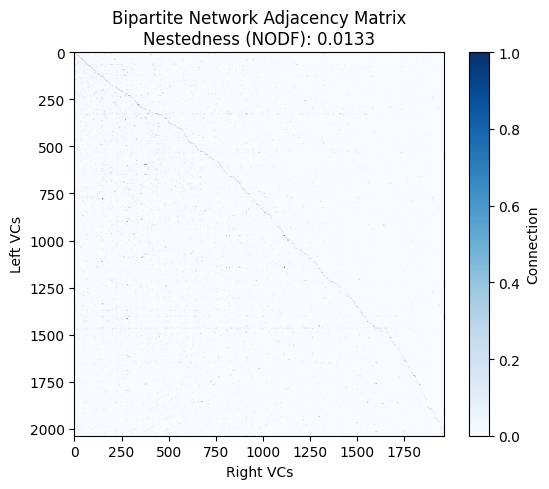

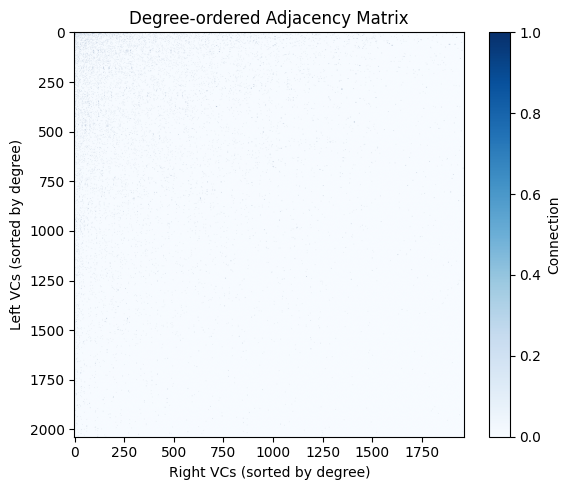

In [407]:
# Create the bipartite adjacency matrix
# Extract unique left and right VCs to define matrix dimensions
left_vcs = vc_vc_inv_pairs_clean['investor_name_left_vc'].unique()
right_vcs = vc_vc_inv_pairs_clean['investor_name_right_vc'].unique()

# Create index mappings for efficient matrix construction
left_vc_indices = {vc: i for i, vc in enumerate(left_vcs)}
right_vc_indices = {vc: j for j, vc in enumerate(right_vcs)}

# Initialize matrix with zeros
adjacency_matrix = np.zeros((len(left_vcs), len(right_vcs)))

# Fill matrix with 1s where connections exist
for _, row in vc_vc_inv_pairs_clean.iterrows():
    left_idx = left_vc_indices[row['investor_name_left_vc']]
    right_idx = right_vc_indices[row['investor_name_right_vc']]
    adjacency_matrix[left_idx, right_idx] = 1

calculator = NestednessCalculator(adjacency_matrix)
nestedness_score = calculator.nodf(adjacency_matrix)

print(f"Nestedness (NODF): {nestedness_score:.4f}")

# You can also visualize the adjacency matrix to see patterns
plt.figure(figsize=(6, 5))
plt.imshow(adjacency_matrix, cmap='Blues')
plt.colorbar(label='Connection')
plt.title(f'Bipartite Network Adjacency Matrix\nNestedness (NODF): {nestedness_score:.4f}')
plt.xlabel('Right VCs')
plt.ylabel('Left VCs')
plt.tight_layout()
plt.show()

# Para ordenar explicitamente os nós por grau (número de conexões)
left_degrees = adjacency_matrix.sum(axis=1)
right_degrees = adjacency_matrix.sum(axis=0)
left_order = np.argsort(left_degrees)[::-1]  # Ordem decrescente
right_order = np.argsort(right_degrees)[::-1]  # Ordem decrescente

# Reordenar a matriz
ordered_matrix = adjacency_matrix[left_order][:, right_order]

plt.figure(figsize=(6, 5))
plt.imshow(ordered_matrix, cmap='Blues')
plt.colorbar(label='Connection')
plt.title('Degree-ordered Adjacency Matrix')
plt.xlabel('Right VCs (sorted by degree)')
plt.ylabel('Left VCs (sorted by degree)')
plt.tight_layout()
plt.show()

In [411]:
# Calculate observed nestedness score (already done in your code)
# nestedness_score = calculator.nodf(adjacency_matrix)
print(f"Observed Nestedness (NODF): {nestedness_score:.4f}")

# Generate null models and calculate their nestedness scores
n_iterations = 1000  # Number of null models to generate
n_iterations_cv = 10000  # Number of null models to generate
null_nestedness_scores = []

print(f"Generating {n_iterations} null models (preserving degrees)...")
for i in tqdm(range(n_iterations)):
    # Generate a null model matrix by swapping while preserving degrees
    M = adjacency_matrix.copy()
    r_hp = find_presences(M)
    RM = curve_ball(M, r_hp, n_iterations_cv)
    
    null_matrix = RM.astype(adjacency_matrix.dtype)

    # Calculate nestedness of the null model
    try:
        calculator_null = NestednessCalculator(null_matrix)
        null_score = calculator_null.nodf(null_matrix)
        null_nestedness_scores.append(null_score)
    except Exception as e:
        print(f"Error in iteration {i}: {e}")

Observed Nestedness (NODF): 0.0133
Generating 1000 null models (preserving degrees)...


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]



Nestedness Significance Analysis:
Observed NODF: 0.0133
Null model mean NODF: 0.0129
Null model std dev: 0.0002
Z-score: 1.9159
Empirical p-value: 0.0310
Significance: Significant at α=0.05


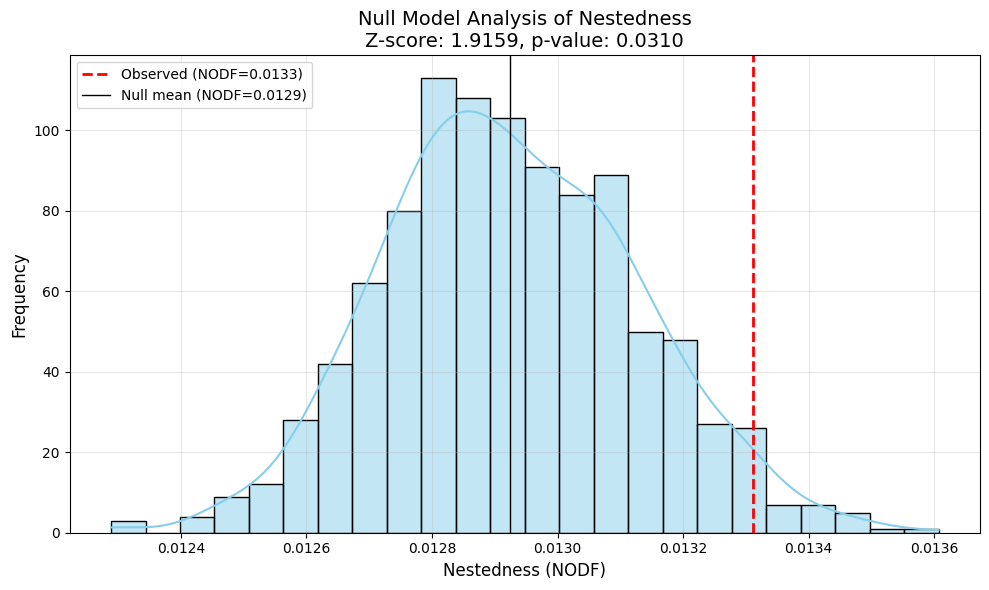

In [412]:
# Convert to numpy array for calculations
null_nestedness_scores_np = np.array(null_nestedness_scores)

# Calculate statistics
mean_null = np.mean(null_nestedness_scores_np)
std_null = np.std(null_nestedness_scores_np)
z_score = (nestedness_score - mean_null) / std_null
p_value = np.sum(null_nestedness_scores_np >= nestedness_score) / len(null_nestedness_scores_np)

print("\nNestedness Significance Analysis:")
print(f"Observed NODF: {nestedness_score:.4f}")
print(f"Null model mean NODF: {mean_null:.4f}")
print(f"Null model std dev: {std_null:.4f}")
print(f"Z-score: {z_score:.4f}")
print(f"Empirical p-value: {p_value:.4f}")
print(f"Significance: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05")

# Visualize the results
plt.figure(figsize=(10, 6))
sns.histplot(null_nestedness_scores_np, kde=True, color='skyblue')
plt.axvline(nestedness_score, color='red', linestyle='--', linewidth=2, 
            label=f'Observed (NODF={nestedness_score:.4f})')
plt.axvline(mean_null, color='black', linestyle='-', linewidth=1, 
            label=f'Null mean (NODF={mean_null:.4f})')
plt.title(f'Null Model Analysis of Nestedness\nZ-score: {z_score:.4f}, p-value: {p_value:.4f}', 
          fontsize=14)
plt.xlabel('Nestedness (NODF)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [413]:
error_please

NameError: name 'error_please' is not defined

#### Comments

...

## Time Series Ecological Network Analysis

### Snapshot-based analysis

Not yet implemented...

In [ ]:
""" # Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_vc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_vc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            cur_year_vc_vc_inv_pairs[['investor_name_left_vc', 'investor_name_right_vc', 'total_funding_usd']],
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd',
            'VCs left',
            'VCs right',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_vcs_left': basic_metrics['set_0_size'],
            'num_vcs_right': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            # 'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years") """

' # Initialize storage for time series metrics\ntime_series_metrics = []\n\n# Minimum number of edges required for meaningful analysis\nmin_edges_threshold = 10\n\nprint("Computing ecological metrics for each year...")\nprint("=" * 50)\n\n# Loop through each year and calculate metrics\nfor year in range(min_year, max_year + 1):\n    cur_year_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts[\'year\'] == year]\n\n    if len(cur_year_vc_vc_inv_pairs) < min_edges_threshold:\n        print(f"Year {year}: Skipping (only {len(cur_year_vc_vc_inv_pairs)} investments)")\n        continue\n\n    try:\n        # Analyze bipartite structure for this year\n        year_analysis = analyze_bipartite_structure_robust(\n            cur_year_vc_vc_inv_pairs[[\'investor_name_left_vc\', \'investor_name_right_vc\', \'total_funding_usd\']],\n            \'investor_name_left_vc\',\n            \'investor_name_right_vc\',\n            \'total_funding_usd\',\n            \'VCs left\',\n            \'VCs 

In [ ]:
""" # Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis") """

' # Convert to DataFrame for easier analysis and plotting\nts_df = pd.DataFrame(time_series_metrics)\n\nif len(ts_df) > 0:\n    print("Time Series Metrics Summary:")\n    print(ts_df.describe().round(3))\n\n    print(f"\nData available for years: {ts_df[\'year\'].min()} to {ts_df[\'year\'].max()}")\n    print(f"Number of years analyzed: {len(ts_df)}")\nelse:\n    print("No time series data available for analysis") '

Evolution of ecological metrics over time in the accelerator-VC ecosystem.

In [ ]:
""" if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 5, figsize=(24, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[2].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[3].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[3].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[3].set_title('Network Size Evolution', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(ts_df['year'], ts_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[4].plot(ts_df['year'], ts_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[4].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[4].set_xlabel('Year')
    axes[4].set_ylabel('Number of Actors')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization") """

' if len(ts_df) > 0:\n    # Create comprehensive time series plot\n    fig, axes = plt.subplots(1, 5, figsize=(24, 4))\n    fig.suptitle(\'Evolution of Ecological Network Metrics - VC-VC Ecosystem\', \n                 fontsize=16, fontweight=\'bold\')\n\n    # Connectance evolution\n    axes[0].plot(ts_df[\'year\'], ts_df[\'connectance\'], \'o-\', linewidth=2, markersize=6, color=\'steelblue\')\n    axes[0].set_title(\'Connectance / Density Evolution\', fontweight=\'bold\')\n    axes[0].set_xlabel(\'Year\')\n    axes[0].set_ylabel(\'Connectance\')\n    axes[0].grid(True, alpha=0.3)\n    axes[0].set_ylim(0, max(ts_df[\'connectance\']) * 1.1)\n\n    # Nestedness evolution\n    axes[1].plot(ts_df[\'year\'], ts_df[\'nestedness_nodf\'], \'o-\', linewidth=2, markersize=6, color=\'forestgreen\')\n    axes[1].set_title(\'Nestedness (NODF) Evolution\', fontweight=\'bold\')\n    axes[1].set_xlabel(\'Year\')\n    axes[1].set_ylabel(\'Nestedness (NODF)\')\n    axes[1].grid(True, alpha=0.3)\n\n   

In [ ]:
""" if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)") """

' if len(ts_df) > 1:\n    # Calculate trends and correlations\n    print("=== Temporal Trends Analysis ===")\n\n    # Calculate year-over-year changes\n    ts_df_sorted = ts_df.sort_values(\'year\')\n\n    metrics_to_analyze = [\'connectance\', \'nestedness_nodf\', \'modularity\', \'num_nodes\', \'num_edges\']\n\n    print("\nYear-over-Year Changes (average):")\n    for metric in metrics_to_analyze:\n        if metric in ts_df_sorted.columns:\n            # Calculate differences\n            diffs = ts_df_sorted[metric].diff().dropna()\n            avg_change = diffs.mean()\n            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]\n            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")\n\n    # Correlation analysis\n    print("\nCorrelations between metrics and time:")\n    for metric in [\'connectance\', \'nestedness_nodf\', \'modularity\']:\n        if metric in ts_df.columns:\n            correlation = ts_df[\'year\'].c

### Cumulative network analysis (5 years window)

In [ ]:
# Initialize storage for time series metrics
cumulative_nestedness_scores_ts = []
cumulative_null_nestedness_scores_ts = []
cumulative_window = 5

vc_vc_inv_pairs_ts = vc_vc_inv_pairs_clean.copy()

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year + cumulative_window, max_year + 1):
    cur_window_vc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] <= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        left_vcs_ts = cur_window_vc_vc_inv_pairs['investor_name_left_vc'].unique()
        right_vcs_ts = cur_window_vc_vc_inv_pairs['investor_name_right_vc'].unique()

        # Create index mappings for efficient matrix construction
        left_vc_indices_ts = {vc: i for i, vc in enumerate(left_vcs_ts)}
        right_vc_indices_ts = {vc: j for j, vc in enumerate(right_vcs_ts)}

        # Initialize matrix with zeros
        adjacency_matrix_ts = np.zeros((len(left_vcs_ts), len(right_vcs_ts)))

        # Fill matrix with 1s where connections exist
        for _, row in cur_window_vc_vc_inv_pairs.iterrows():
            left_idx_ts = left_vc_indices_ts[row['investor_name_left_vc']]
            right_idx_ts = right_vc_indices_ts[row['investor_name_right_vc']]
            adjacency_matrix_ts[left_idx_ts, right_idx_ts] = 1

        calculator_ts = NestednessCalculator(adjacency_matrix_ts)
        nestedness_score_ts = calculator_ts.nodf(adjacency_matrix_ts)
        
        null_nestedness_scores_ts = []
        n_iterations = 10
        n_iterations_cv = 100
        print(f"Generating {n_iterations} null models (preserving degrees)...")
        for i in tqdm(range(n_iterations)):
            # Generate a null model matrix by swapping while preserving degrees
            M = adjacency_matrix.copy()
            r_hp = find_presences(M)
            RM = curve_ball(M, r_hp, n_iterations_cv)
            
            null_matrix = RM.astype(adjacency_matrix.dtype)

            # Calculate nestedness of the null model
            try:
                calculator_null = NestednessCalculator(null_matrix)
                null_score = calculator_null.nodf(null_matrix)
                null_nestedness_scores_ts.append(null_score)
            except Exception as e:
                print(f"Error in iteration {i}: {e}")
                
        null_nestedness_scores_np = np.array(null_nestedness_scores_ts)

        # Calculate statistics
        mean_null = np.mean(null_nestedness_scores_np)
        std_null = np.std(null_nestedness_scores_np)
        z_score = (nestedness_score_ts - mean_null) / std_null
        p_value = np.sum(null_nestedness_scores_np >= nestedness_score_ts) / len(null_nestedness_scores_np)

        num_nodes = len(left_vcs_ts) + len(right_vcs_ts)
        num_vcs_left = len(left_vcs_ts)
        num_vcs_right = len(right_vcs_ts)
        num_edges = int(adjacency_matrix_ts.sum())
        density = adjacency_matrix_ts.mean()
        
        cumulative_nestedness_scores_ts.append({
            'year': year,
            'nestedness_score': nestedness_score_ts,
            'null_nestedness_scores': null_nestedness_scores_np,
            'mean_null': mean_null,
            'std_null': std_null,
            'z_score': z_score,
            'p_value': p_value,
            'year': year,
            'num_nodes': num_nodes,
            'num_vcs_left': num_vcs_left,
            'num_vcs_right': num_vcs_right,
            'num_edges': num_edges,
            'density': density
        })
        
        # Extract metrics        
        print(f"Year {year}: {num_nodes} nodes ({num_vcs_left} left VCs, {num_vcs_right} right VCs), "
              f"{num_edges} edges, Density: {density:.4f}, "
              f"Nestedness: {nestedness_score_ts:.4f}, Mean null: {mean_null:.4f}, "
              f"Std null: {std_null:.4f}, Z-score: {z_score:.4f}, P-value: {p_value:.4f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(cumulative_nestedness_scores_ts)} years")

Computing ecological metrics for each year (5 years window)...
Generating 10 null models (preserving degrees)...


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Year 2010: 926 nodes (409 left VCs, 517 right VCs), 2729 edges, Density: 0.0129, Nestedness: 0.0209, Mean null: 0.0287, Std null: 0.0000, Z-score: -231.3002, P-value: 1.0000
Generating 10 null models (preserving degrees)...


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Year 2011: 1026 nodes (461 left VCs, 565 right VCs), 2867 edges, Density: 0.0110, Nestedness: 0.0168, Mean null: 0.0287, Std null: 0.0000, Z-score: -701.2634, P-value: 1.0000
Generating 10 null models (preserving degrees)...


 70%|███████   | 7/10 [00:10<00:04,  1.54s/it]


KeyboardInterrupt: 

In [ ]:
# Convert to DataFrame for easier analysis and plotting
cumulative_nestedness_scores_df = pd.DataFrame(cumulative_nestedness_scores_ts)

if len(cumulative_nestedness_scores_df) > 0:
    print("Time Series Metrics Summary:")
    print(cumulative_nestedness_scores_df.describe().round(3))
    
    print(f"\nData available for years: {cumulative_nestedness_scores_df['year'].min()} to {cumulative_nestedness_scores_df['year'].max()}")
    print(f"Number of years analyzed: {len(cumulative_nestedness_scores_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  nestedness_score  mean_null  std_null  z_score  p_value  \
count     4.000             4.000      4.000       4.0    4.000      4.0   
mean   2011.500             0.017      0.022       0.0  -99.540      1.0   
std       1.291             0.001      0.000       0.0   25.226      0.0   
min    2010.000             0.016      0.022       0.0 -119.350      1.0   
25%    2010.750             0.016      0.022       0.0 -113.853      1.0   
50%    2011.500             0.016      0.022       0.0 -107.951      1.0   
75%    2012.250             0.017      0.022       0.0  -93.639      1.0   
max    2013.000             0.018      0.022       0.0  -62.908      1.0   

       num_nodes  num_vcs_left  num_vcs_right  num_edges  density  
count      4.000         4.000          4.000      4.000    4.000  
mean    1305.250       594.750        710.500   4184.250    0.010  
std      142.172        79.726         62.703    658.127    0.001  
min     1132.0

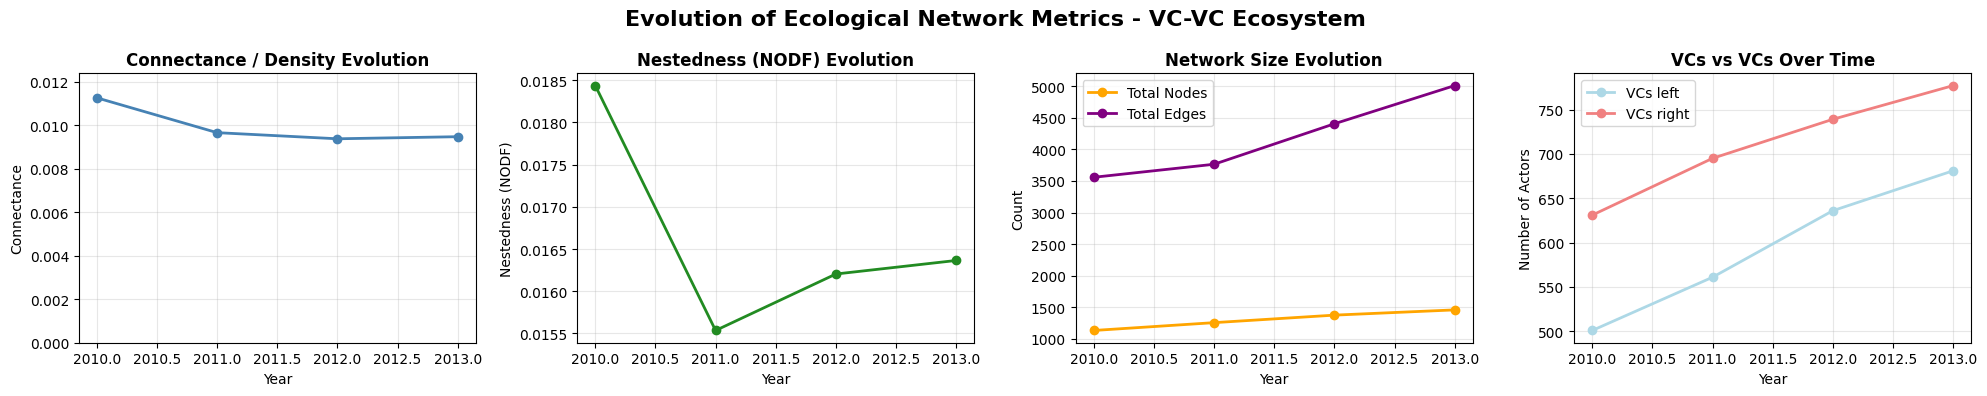

In [ ]:
if len(cumulative_nestedness_scores_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - VC-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['density'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(cumulative_nestedness_scores_df['density']) * 1.1)
    
    # Nestedness evolution
    axes[1].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['nestedness_score'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Nestedness (NODF)')
    axes[1].grid(True, alpha=0.3)
    
    # Modularity evolution
    """ axes[2].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[2].set_title('Modularity Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Modularity')
    axes[2].grid(True, alpha=0.3) """
    
    # Network size evolution
    axes[2].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[2].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[2].set_title('Network Size Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Count')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_vcs_left'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='VCs left')
    axes[3].plot(cumulative_nestedness_scores_df['year'], cumulative_nestedness_scores_df['num_vcs_right'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs right')
    axes[3].set_title('VCs vs VCs Over Time', fontweight='bold')
    axes[3].set_xlabel('Year')
    axes[3].set_ylabel('Number of Actors')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")


Nestedness Significance Analysis for Year 2010:
Observed NODF: 0.0184
Null model mean NODF: 0.0223
Null model std dev: 0.0001
Z-score: -62.9077
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2011:
Observed NODF: 0.0155
Null model mean NODF: 0.0223
Null model std dev: 0.0001
Z-score: -119.3504
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2012:
Observed NODF: 0.0162
Null model mean NODF: 0.0223
Null model std dev: 0.0001
Z-score: -103.8822
Empirical p-value: 1.0000
Significance: Not significant at α=0.05

Nestedness Significance Analysis for Year 2013:
Observed NODF: 0.0164
Null model mean NODF: 0.0223
Null model std dev: 0.0001
Z-score: -112.0205
Empirical p-value: 1.0000
Significance: Not significant at α=0.05


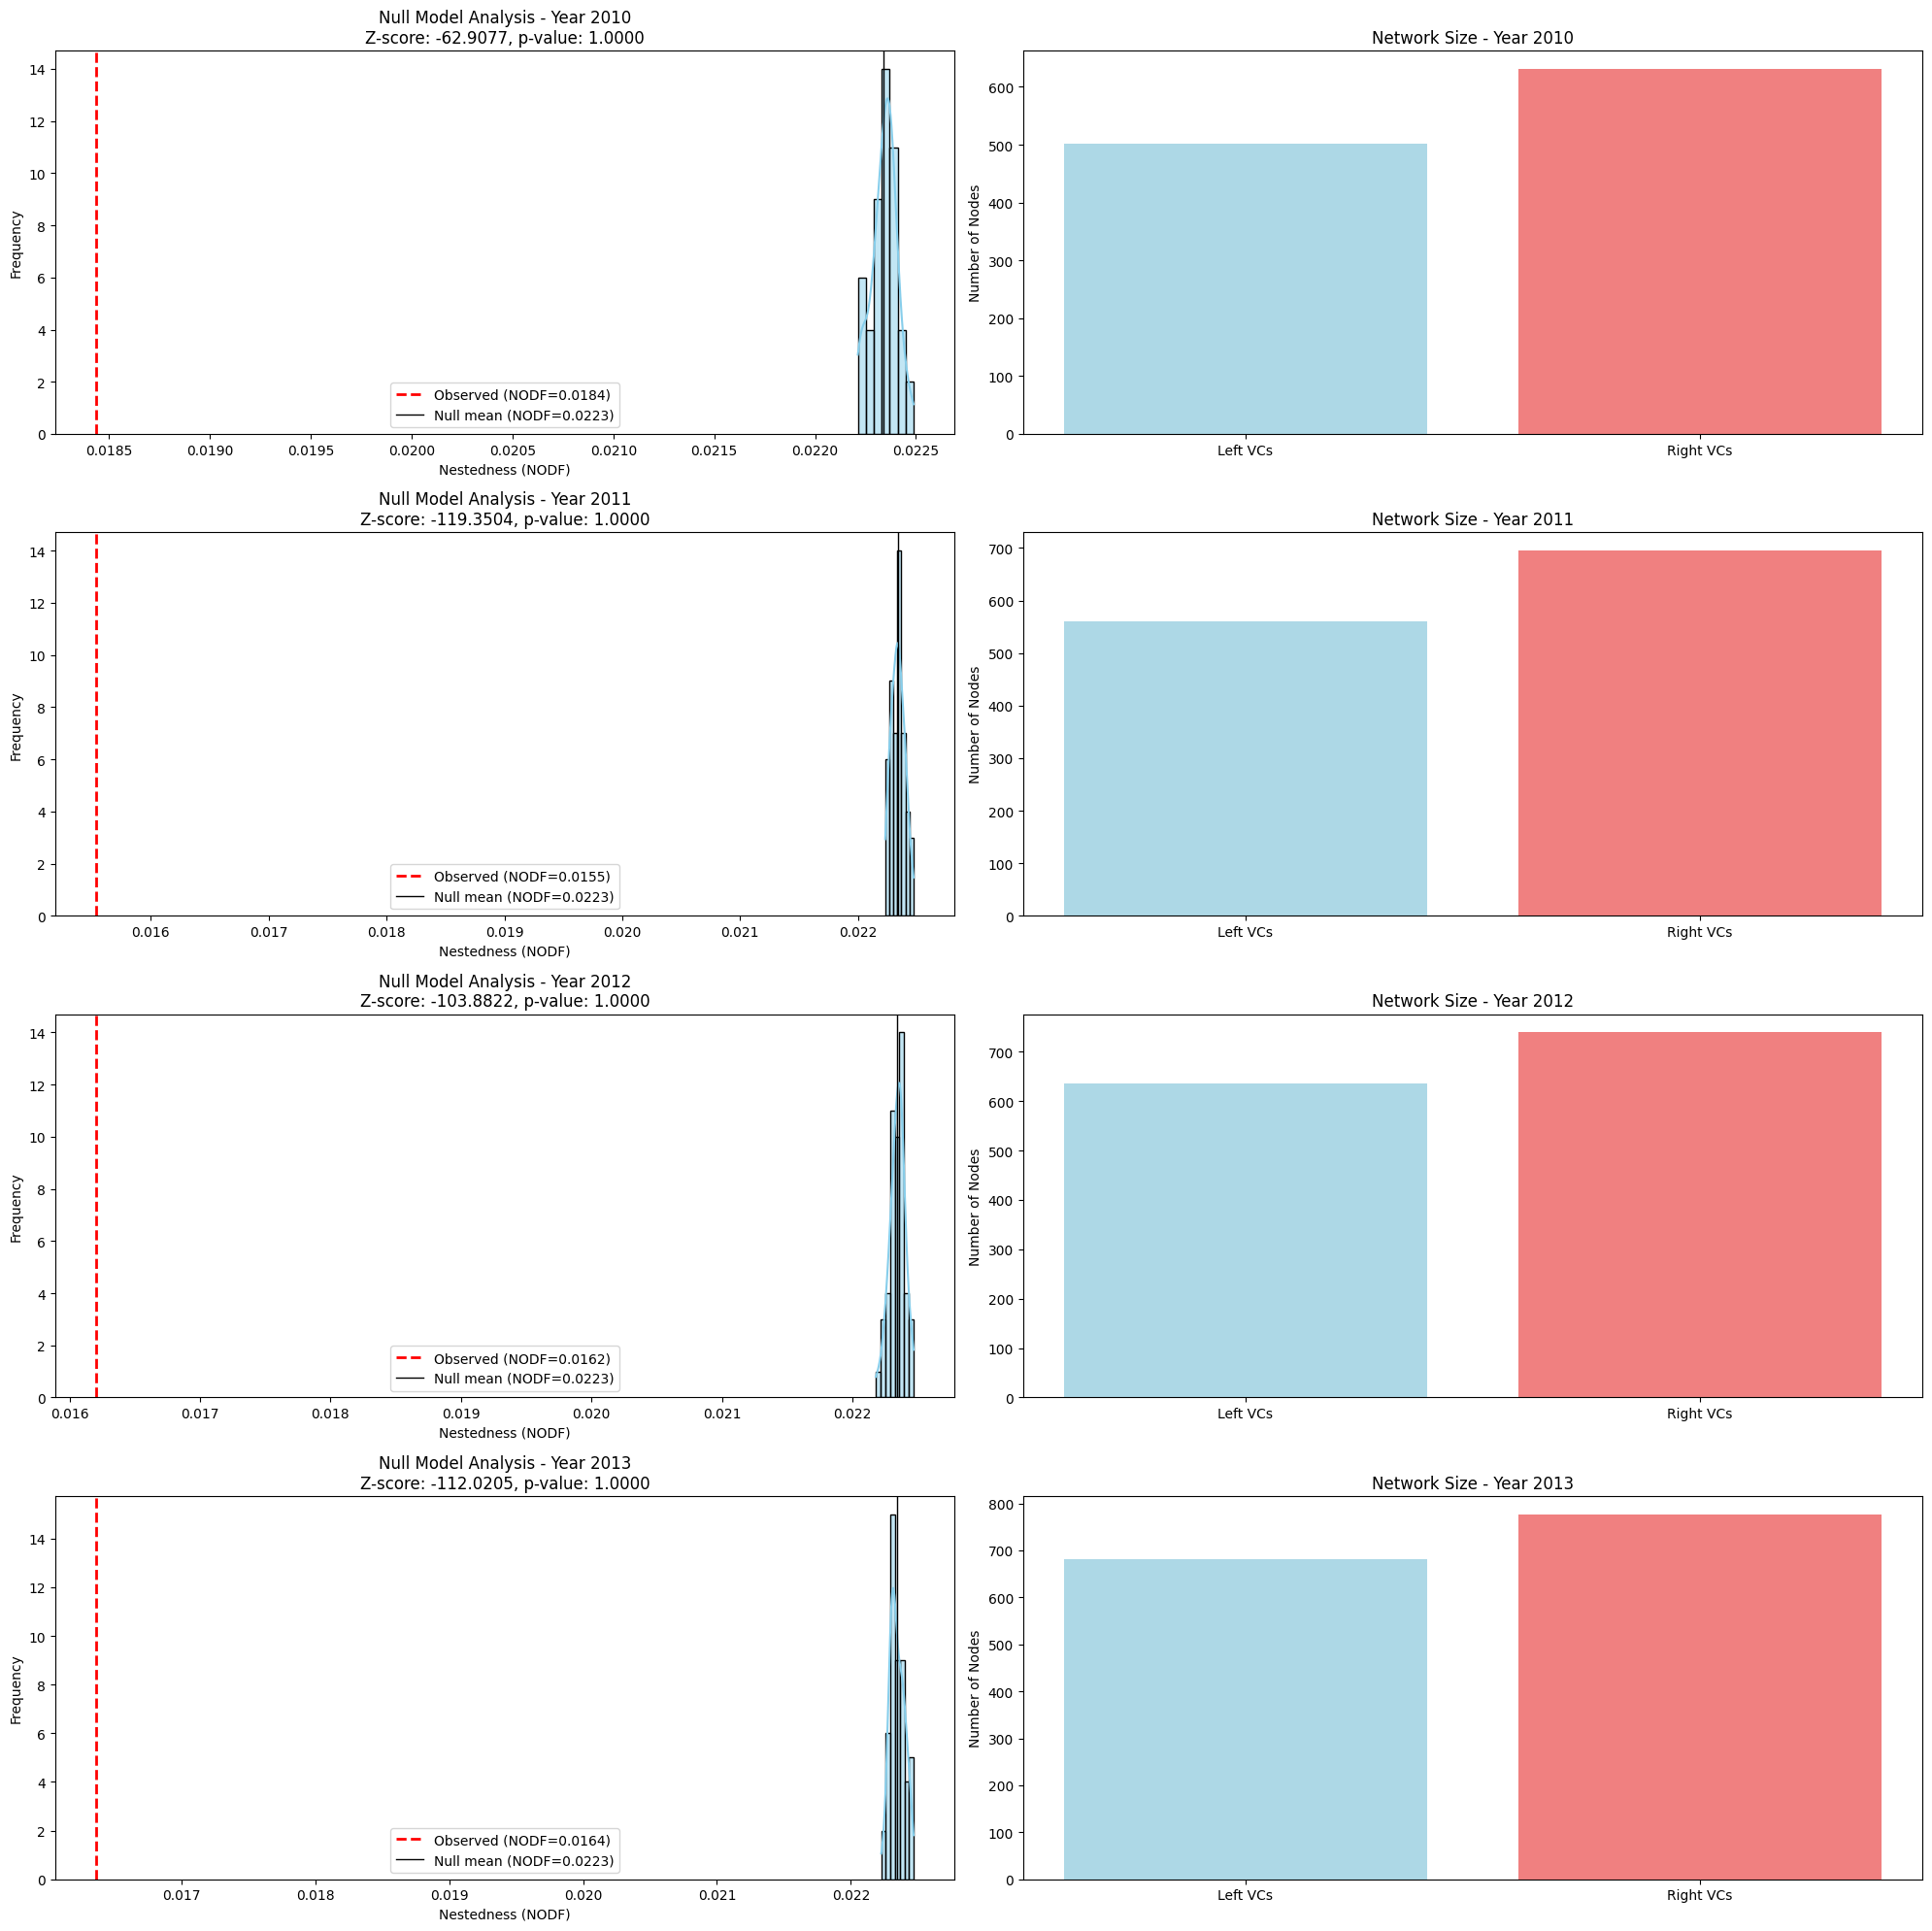

In [ ]:
# Create visualizations for each year to show nestedness significance
fig, axes = plt.subplots(len(cumulative_nestedness_scores_df), 2, figsize=(20, 5*len(cumulative_nestedness_scores_df)))

for i, (idx, row) in enumerate(cumulative_nestedness_scores_df.iterrows()):
  year = row['year']
  nestedness_score = row['nestedness_score']
  null_nestedness_scores = row['null_nestedness_scores']
  mean_null = row['mean_null']
  std_null = row['std_null']
  z_score = row['z_score']
  p_value = row['p_value']
  
  # Print statistics for the year
  print(f"\nNestedness Significance Analysis for Year {year}:")
  print(f"Observed NODF: {nestedness_score:.4f}")
  print(f"Null model mean NODF: {mean_null:.4f}")
  print(f"Null model std dev: {std_null:.4f}")
  print(f"Z-score: {z_score:.4f}")
  print(f"Empirical p-value: {p_value:.4f}")
  print(f"Significance: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05")
  
  # Plot 1: Histogram of null model distribution
  sns.histplot(null_nestedness_scores, kde=True, color='skyblue', ax=axes[i, 0])
  axes[i, 0].axvline(nestedness_score, color='red', linestyle='--', linewidth=2, 
        label=f'Observed (NODF={nestedness_score:.4f})')
  axes[i, 0].axvline(mean_null, color='black', linestyle='-', linewidth=1, 
        label=f'Null mean (NODF={mean_null:.4f})')
  axes[i, 0].set_title(f'Null Model Analysis - Year {year}\nZ-score: {z_score:.4f}, p-value: {p_value:.4f}')
  axes[i, 0].set_xlabel('Nestedness (NODF)')
  axes[i, 0].set_ylabel('Frequency')
  axes[i, 0].legend()
  
  # Plot 2: Network properties
  ax2 = axes[i, 1]
  ax2.bar(['Left VCs', 'Right VCs'], [row['num_vcs_left'], row['num_vcs_right']], color=['lightblue', 'lightcoral'])
  ax2.set_title(f'Network Size - Year {year}')
  ax2.set_ylabel('Number of Nodes')
  
plt.tight_layout()
plt.show()